In [1]:
import keras
from   keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from   tensorflow.python.keras.datasets import fashion_mnist

%matplotlib inline

Using TensorFlow backend.


In [2]:
BATCH = 128
EPOCHS = 20
N_CLASSES = 10
ETA = 0.1
WIDTH, HEIGHT = 28, 28

In [3]:
fashion_labels = [
    # 0          1           2           3        4       5
    'Shirt/top', 'Trousers', 'Pullover', 'Dress', 'Coat', 'Sandal', 
    # 6          7           8           9
    'Shirt',     'Sneaker',  'Bag',      'Ankle boot']
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [4]:
# Flatten:
X_train = X_train.reshape((60000, WIDTH * HEIGHT))
X_test = X_test.reshape((10000, WIDTH * HEIGHT))

In [5]:
SPLIT = 50000
(X_train, X_valid) = X_train[:SPLIT], X_train[SPLIT:]
(y_train, y_valid) = y_train[:SPLIT], y_train[SPLIT:]

In [6]:
# One-Hot Encoding for lables
y_train_1 = tf.one_hot(y_train, depth=N_CLASSES).numpy()
y_valid_1 = tf.one_hot(y_valid, depth=N_CLASSES).numpy()
y_test_1 = tf.one_hot(y_test, depth=N_CLASSES).numpy()

Ankle boot Shirt/top Shirt/top Dress Shirt/top Pullover Sneaker Pullover Sandal Sandal 

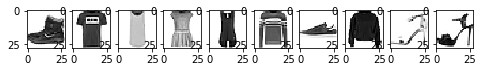

In [7]:
# Sample images
_, image = plt.subplots(1, N_CLASSES, figsize=(8, 1))

for i in range(N_CLASSES):
    image[i].imshow(np.reshape(X_train[i], (WIDTH, HEIGHT)), cmap='Greys')
    print(fashion_labels[y_train[i]], sep=' ', end=' ')

In [8]:
# Canonical Google approach for modeling (subclass tf.keras.Model)
class LogisticRegression(tf.keras.Model):
    def __init__(self, n_classes):
        super(LogisticRegression, self).__init__()
        self.dense = tf.keras.layers.Dense(n_classes)
        
    def call(self, inputs, training=None, mask=None):
        output = self.dense(inputs)
        # softmax op does not exist on GPU so force CPU
        with tf.device('/cpu:0'):
            output = tf.nn.softmax(output)
        return output

In [9]:
mod = LogisticRegression(N_CLASSES)
optimizer = tf.optimizers.SGD(ETA)
#optimizer = tf.keras.optimizers.Adam() # not supported in eager mode
mod.compile(optimizer=optimizer, 
            loss='categorical_crossentropy', 
            metrics=['accuracy'])

In [ ]:
# TF Keras tries to use the entire dataset to determine the shape without 
# this step when using .fit() So, use one sample of the provided input 
# data set size to determine input/output shapes for the model
X_dummy = tf.zeros((1, WIDTH * HEIGHT)) 
mod.call(X_dummy)

# Causes jupyter kernel to crash...! Can (prob) run as .py

In [ ]:
weight_path = './mod.w.best.hdf5'
checkpointer = ModelCheckpoint(filepath=weight_path, 
                               verbose=2, 
                               save_best_only=True, 
                               save_weights_only=True)
mod.fit(X_train, 
        y_train_1, 
        batch_size=BATCH, 
        epochs=EPOCHS, 
        validation_data=(X_valid, y_valid_1), 
        callbacks=[checkpointer], 
        verbose=2)
mod.load_weights(weight_path)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20


In [ ]:
scores = mod.evaluate(X_test, y_test_1, BATCH, verbose=2)
print('Acc:', scores)

In [1]:
y_preds = mod.predict(X_test)

NameError: name 'mod' is not defined

In [ ]:
INDEX = 42
i_pred = np.argmax(y_preds[INDEX])
i_actual = np.argmax(y_test_1[INDEX])

print(f'Predicted: {fashion_labels[i_pred]}\n'
      f'Actual: {fashion_labels[i_actual]}')

In [ ]:
print ('\n\nPredicted V (True) fashion labels, green is correct, red is '
       'wrong')
size = 12 # i.e. 12 random numbers chosen
fig = plt.figure(figsize=(15, 3))
rows = 3
cols = 4

In [ ]:
for i, index in enumerate(
        np.random.choice(x_test.shape[0], size=size, replace=False)):
    axis = fig.add_subplot(rows, cols, i + 1, xticks=[], yticks=[])
    axis.imshow(x_test[index].reshape(WIDTH, HEIGHT), cmap="Greys")
    index_predicted = np.argmax(y_predictions[index])
    index_true = np.argmax(y_test_1[index])
    axis.set_title(
        'f{fashion_labels[index_predicted]} ({fashion_labels[index_true]})',
        color=('green' if index_predicted==index_true else 'red'))